In [2]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers
import matplotlib.pyplot as plt
from keras import optimizers
import os
print(os.listdir("../input"))

['coverage', 'sort-bug']


In [5]:
coverage = pd.read_csv('../input/sort-bug/sort_bug1.csv')
coverage # check coverage information

,,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30,s31,s32,s33,s34,s35,s36,s37,s38,s39,...,s52,s53,s54,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64,s65,s66,s67,s68,s69,s70,s71,s72,s73,s74,s75,s76,s77,s78,s79,s80,s81,s82,s83,s84,s85,s86,s87,s88,s89,s90,r
0,t1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
1,t2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
2,t3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
3,t4,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
4,t5,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
5,t6,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
6,t7,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
7,t8,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1
8,t9,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0
9,t10,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0


In [6]:
def read_coverage(inputstream):
    coverage = pd.read_csv(inputstream)
    rows, columns = coverage.shape
    m = coverage[coverage.columns[1:-1]]
    m = np.matrix(m)
    result = coverage[coverage.columns[-1]]
    result = np.array(result)
    return m, result, columns-2

In [7]:
#######################################
#           Procedure I               #
#######################################

def get_train_data(): # simulate, example in BPNN paper
    m = np.matrix([
        [1,1,1,1,0,1,0,0,1],
        [1,0,0,0,1,1,1,1,0],
        [0,0,0,0,0,1,1,0,0],
        [1,1,0,0,1,0,1,1,1],
        [1,1,1,0,1,1,1,1,1],
        [0,0,1,0,0,1,1,1,0],
        [1,1,1,1,0,1,0,1,1]
    ]).astype(int)
    result = np.array([0,0,0,0,0,1,1])
    return m, result

def create_virtual_test(n):
    c = np.diag(np.ones(n-1), 1) 
    return c

def build_model(n_statement):
    model = Sequential()
    # input layer is m.size
    # hidden layer one
    initiallizer = initializers.RandomUniform(minval=-0.01*n_statement, maxval=0.01*n_statement, seed=None)
    model.add(Dense(3, input_dim=n_statement, activation='relu', 
                    kernel_initializer= initiallizer,
                    bias_initializer='zeros',
                    kernel_regularizer=regularizers.l2(0.01)))
    # hidden layer 
#     model.add(Dense(3, activation='sigmoid', 
#                     kernel_regularizer=regularizers.l2(0.01)
#                    ))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model    


def train_model(m,result,n_statement,epochs):
    model = build_model(n_statement)
    #sgd = optimizers.SGD(lr=0.3, decay=1e-6, momentum=0.9, nesterov=True)
    rmsprop = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer= rmsprop, metrics=['accuracy'])
    history = model.fit(m, result, epochs=epochs) #  batch_size=10

    # summarize history for accuracy
#     plt.plot(history.history['acc'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return model

def selectionSort(rlist):
    index = [x for x in range(len(rlist))]
    rank = [x for x in range(len(rlist))]
    for i in range(len(index)):
        idx = i
        j = i+1
        while j > i and j < len(index):
            if (rlist[idx] < rlist[j]):
                idx = j
            j+=1
        rlist[i],rlist[idx] = swap(rlist[i],rlist[idx])
        index[i], index[idx] = index[idx], index[i]
        i+=1
    return rank, index

def swap(a,b): # just for np.array
    temp = a.copy()
    a = b
    b = temp
    return a, b

#######################################
#           Procedure II              #
#######################################

def find_si(m, result, n_statement):
    si = np.zeros(n_statement)
    for i in range(result.size):
        if result[i] == 0:  
            continue
        for j in range(n_statement):
            if m[i,j] == 0: 
                si[j]-=10000 # assume n_statement < 10000
            else:
                si[j]+=1
    for j in range(n_statement):
        if (si[j] <= 0): si[j] = 0
        else: si[j] = 1
    return si

def find_sm(m, result):
    t = np.zeros(result.size)
    minidx = 0
    minsum = 10000 # assume n_statement < 10000
    for i in range(result.size):
        if result[i] == 0:  
            continue
        t[i] = np.sum(m[i])
        if t[i] < minsum:
            minsum = t[i]
            minidx = i
    sm = m[minidx]
    return sm

def procedure1(r_virtual):
    r_virtual1 = r_virtual.copy()
    rank, index= selectionSort(r_virtual1)
    print("Procedure I")
    for i in range(len(rank)):
        print("Statement {:>2}: {:>4}".format(index[i]+1,rank[i]+1))
        
def procedure2(r_virtual): # improvement suggested in paper
    r_virtual2 = r_virtual.copy()
    print("Procedure II (improvement)")
    # Procedure II
    si = find_si(m,result,n_statement)
    sm = find_sm(m,result)
    for i in range(len(si)):
        if(si[i] != 0 and sm[0,i] != 0):
            r_virtual2[i] +=2.0
            print("Statement {:>2} should be checked firstly (Si)".format(i+1))
        if(si[i] == 0 and sm[0,i] == 1):
            r_virtual2[i] +=1.0
            print("Statement {:>2} should be checked secondly (Sm)".format(i+1))
    rank, index= selectionSort(r_virtual2)
    print("Final Result")
    for i in range(len(rank)):
        print("Statement {:>2}: {:>4}".format(index[i]+1,rank[i]+1))
    

Epoch 1/4500
20/20 [==============================] - 1s 26ms/step - loss: 1.0706 - acc: 0.9500
Epoch 2/4500
20/20 [==============================] - 0s 143us/step - loss: 0.9733 - acc: 0.9500
Epoch 3/4500
20/20 [==============================] - 0s 201us/step - loss: 0.9010 - acc: 0.9500
Epoch 4/4500
20/20 [==============================] - 0s 185us/step - loss: 0.8528 - acc: 0.9500
Epoch 5/4500
20/20 [==============================] - 0s 179us/step - loss: 0.8132 - acc: 0.9500
Epoch 6/4500
20/20 [==============================] - 0s 190us/step - loss: 0.7708 - acc: 0.9500
Epoch 7/4500
20/20 [==============================] - 0s 178us/step - loss: 0.7356 - acc: 0.9500
Epoch 8/4500
20/20 [==============================] - 0s 188us/step - loss: 0.7094 - acc: 0.9500
Epoch 9/4500
20/20 [==============================] - 0s 159us/step - loss: 0.6773 - acc: 0.9500
Epoch 10/4500
20/20 [==============================] - 0s 146us/step - loss: 0.6495 - acc: 0.9500
Epoch 11/4500
20/20 [=========

Epoch 85/4500
20/20 [==============================] - 0s 115us/step - loss: 0.0703 - acc: 1.0000
Epoch 86/4500
20/20 [==============================] - 0s 139us/step - loss: 0.0711 - acc: 1.0000
Epoch 87/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0680 - acc: 1.0000
Epoch 88/4500
20/20 [==============================] - 0s 198us/step - loss: 0.0684 - acc: 1.0000
Epoch 89/4500
20/20 [==============================] - 0s 186us/step - loss: 0.0649 - acc: 1.0000
Epoch 90/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0655 - acc: 1.0000
Epoch 91/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0643 - acc: 1.0000
Epoch 92/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0634 - acc: 1.0000
Epoch 93/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0626 - acc: 1.0000
Epoch 94/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0593 - acc: 1.0000
Epoch 95/4500
20/20 [

20/20 [==============================] - 0s 174us/step - loss: 0.0279 - acc: 1.0000
Epoch 169/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0284 - acc: 1.0000
Epoch 170/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0276 - acc: 1.0000
Epoch 171/4500
20/20 [==============================] - 0s 126us/step - loss: 0.0278 - acc: 1.0000
Epoch 172/4500
20/20 [==============================] - 0s 94us/step - loss: 0.0272 - acc: 1.0000
Epoch 173/4500
20/20 [==============================] - 0s 144us/step - loss: 0.0275 - acc: 1.0000
Epoch 174/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0270 - acc: 1.0000
Epoch 175/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0270 - acc: 1.0000
Epoch 176/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0265 - acc: 1.0000
Epoch 177/4500
20/20 [==============================] - 0s 99us/step - loss: 0.0268 - acc: 1.0000
Epoch 178/4500
20/20 [=========

20/20 [==============================] - 0s 125us/step - loss: 0.0172 - acc: 1.0000
Epoch 252/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0174 - acc: 1.0000
Epoch 253/4500
20/20 [==============================] - 0s 163us/step - loss: 0.0172 - acc: 1.0000
Epoch 254/4500
20/20 [==============================] - 0s 115us/step - loss: 0.0180 - acc: 1.0000
Epoch 255/4500
20/20 [==============================] - 0s 142us/step - loss: 0.0171 - acc: 1.0000
Epoch 256/4500
20/20 [==============================] - 0s 163us/step - loss: 0.0185 - acc: 1.0000
Epoch 257/4500
20/20 [==============================] - 0s 142us/step - loss: 0.0173 - acc: 1.0000
Epoch 258/4500
20/20 [==============================] - 0s 134us/step - loss: 0.0187 - acc: 1.0000
Epoch 259/4500
20/20 [==============================] - 0s 204us/step - loss: 0.0170 - acc: 1.0000
Epoch 260/4500
20/20 [==============================] - 0s 201us/step - loss: 0.0183 - acc: 1.0000
Epoch 261/4500
20/20 [===

Epoch 334/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0136 - acc: 1.0000
Epoch 335/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0131 - acc: 1.0000
Epoch 336/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0128 - acc: 1.0000
Epoch 337/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0127 - acc: 1.0000
Epoch 338/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0123 - acc: 1.0000
Epoch 339/4500
20/20 [==============================] - 0s 141us/step - loss: 0.0120 - acc: 1.0000
Epoch 340/4500
20/20 [==============================] - 0s 165us/step - loss: 0.0127 - acc: 1.0000
Epoch 341/4500
20/20 [==============================] - 0s 149us/step - loss: 0.0119 - acc: 1.0000
Epoch 342/4500
20/20 [==============================] - 0s 147us/step - loss: 0.0115 - acc: 1.0000
Epoch 343/4500
20/20 [==============================] - 0s 154us/step - loss: 0.0122 - acc: 1.0000
Epoch 344/450

Epoch 417/4500
20/20 [==============================] - 0s 132us/step - loss: 0.0106 - acc: 1.0000
Epoch 418/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0150 - acc: 1.0000
Epoch 419/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0254 - acc: 1.0000
Epoch 420/4500
20/20 [==============================] - 0s 146us/step - loss: 0.0333 - acc: 1.0000
Epoch 421/4500
20/20 [==============================] - 0s 123us/step - loss: 0.0188 - acc: 1.0000
Epoch 422/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0119 - acc: 1.0000
Epoch 423/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0114 - acc: 1.0000
Epoch 424/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0111 - acc: 1.0000
Epoch 425/4500
20/20 [==============================] - 0s 112us/step - loss: 0.0109 - acc: 1.0000
Epoch 426/4500
20/20 [==============================] - 0s 90us/step - loss: 0.0106 - acc: 1.0000
Epoch 427/450

Epoch 500/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0100 - acc: 1.0000
Epoch 501/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0097 - acc: 1.0000
Epoch 502/4500
20/20 [==============================] - 0s 229us/step - loss: 0.0093 - acc: 1.0000
Epoch 503/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0090 - acc: 1.0000
Epoch 504/4500
20/20 [==============================] - 0s 171us/step - loss: 0.0091 - acc: 1.0000
Epoch 505/4500
20/20 [==============================] - 0s 172us/step - loss: 0.0097 - acc: 1.0000
Epoch 506/4500
20/20 [==============================] - 0s 161us/step - loss: 0.0088 - acc: 1.0000
Epoch 507/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0089 - acc: 1.0000
Epoch 508/4500
20/20 [==============================] - 0s 164us/step - loss: 0.0101 - acc: 1.0000
Epoch 509/4500
20/20 [==============================] - 0s 168us/step - loss: 0.0096 - acc: 1.0000
Epoch 510/4

Epoch 583/4500
20/20 [==============================] - 0s 109us/step - loss: 0.0090 - acc: 1.0000
Epoch 584/4500
20/20 [==============================] - 0s 144us/step - loss: 0.0088 - acc: 1.0000
Epoch 585/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0087 - acc: 1.0000
Epoch 586/4500
20/20 [==============================] - 0s 166us/step - loss: 0.0086 - acc: 1.0000
Epoch 587/4500
20/20 [==============================] - 0s 138us/step - loss: 0.0084 - acc: 1.0000
Epoch 588/4500
20/20 [==============================] - 0s 135us/step - loss: 0.0084 - acc: 1.0000
Epoch 589/4500
20/20 [==============================] - 0s 152us/step - loss: 0.0083 - acc: 1.0000
Epoch 590/4500
20/20 [==============================] - 0s 123us/step - loss: 0.0081 - acc: 1.0000
Epoch 591/4500
20/20 [==============================] - 0s 140us/step - loss: 0.0080 - acc: 1.0000
Epoch 592/4500
20/20 [==============================] - 0s 178us/step - loss: 0.0081 - acc: 1.0000
Epoch 593/

Epoch 666/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0090 - acc: 1.0000
Epoch 667/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0087 - acc: 1.0000
Epoch 668/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0084 - acc: 1.0000
Epoch 669/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0081 - acc: 1.0000
Epoch 670/4500
20/20 [==============================] - 0s 155us/step - loss: 0.0079 - acc: 1.0000
Epoch 671/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0076 - acc: 1.0000
Epoch 672/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0075 - acc: 1.0000
Epoch 673/4500
20/20 [==============================] - 0s 129us/step - loss: 0.0074 - acc: 1.0000
Epoch 674/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0074 - acc: 1.0000
Epoch 675/4500
20/20 [==============================] - 0s 131us/step - loss: 0.0072 - acc: 1.0000
Epoch 676/45

20/20 [==============================] - 0s 89us/step - loss: 0.0074 - acc: 1.0000
Epoch 750/4500
20/20 [==============================] - 0s 84us/step - loss: 0.0072 - acc: 1.0000
Epoch 751/4500
20/20 [==============================] - 0s 130us/step - loss: 0.0071 - acc: 1.0000
Epoch 752/4500
20/20 [==============================] - 0s 122us/step - loss: 0.0070 - acc: 1.0000
Epoch 753/4500
20/20 [==============================] - 0s 99us/step - loss: 0.0070 - acc: 1.0000
Epoch 754/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0068 - acc: 1.0000
Epoch 755/4500
20/20 [==============================] - 0s 102us/step - loss: 0.0068 - acc: 1.0000
Epoch 756/4500
20/20 [==============================] - 0s 83us/step - loss: 0.0068 - acc: 1.0000
Epoch 757/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0067 - acc: 1.0000
Epoch 758/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0067 - acc: 1.0000
Epoch 759/4500
20/20 [=========

Epoch 833/4500
20/20 [==============================] - 0s 131us/step - loss: 0.0073 - acc: 1.0000
Epoch 834/4500
20/20 [==============================] - 0s 75us/step - loss: 0.0072 - acc: 1.0000
Epoch 835/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0071 - acc: 1.0000
Epoch 836/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0070 - acc: 1.0000
Epoch 837/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0069 - acc: 1.0000
Epoch 838/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0068 - acc: 1.0000
Epoch 839/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0067 - acc: 1.0000
Epoch 840/4500
20/20 [==============================] - 0s 155us/step - loss: 0.0066 - acc: 1.0000
Epoch 841/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0065 - acc: 1.0000
Epoch 842/4500
20/20 [==============================] - 0s 115us/step - loss: 0.0064 - acc: 1.0000
Epoch 843/4500

Epoch 917/4500
20/20 [==============================] - 0s 83us/step - loss: 0.0059 - acc: 1.0000
Epoch 918/4500
20/20 [==============================] - 0s 100us/step - loss: 0.0059 - acc: 1.0000
Epoch 919/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0059 - acc: 1.0000
Epoch 920/4500
20/20 [==============================] - 0s 135us/step - loss: 0.0059 - acc: 1.0000
Epoch 921/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0060 - acc: 1.0000
Epoch 922/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0060 - acc: 1.0000
Epoch 923/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0061 - acc: 1.0000
Epoch 924/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0060 - acc: 1.0000
Epoch 925/4500
20/20 [==============================] - 0s 123us/step - loss: 0.0065 - acc: 1.0000
Epoch 926/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0069 - acc: 1.0000
Epoch 927/4500
2

Epoch 1001/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0057 - acc: 1.0000
Epoch 1002/4500
20/20 [==============================] - 0s 134us/step - loss: 0.0057 - acc: 1.0000
Epoch 1003/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0056 - acc: 1.0000
Epoch 1004/4500
20/20 [==============================] - 0s 125us/step - loss: 0.0056 - acc: 1.0000
Epoch 1005/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0055 - acc: 1.0000
Epoch 1006/4500
20/20 [==============================] - 0s 189us/step - loss: 0.0055 - acc: 1.0000
Epoch 1007/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0054 - acc: 1.0000
Epoch 1008/4500
20/20 [==============================] - 0s 121us/step - loss: 0.0055 - acc: 1.0000
Epoch 1009/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0054 - acc: 1.0000
Epoch 1010/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0054 - acc: 1.0000
Epo

Epoch 1084/4500
20/20 [==============================] - 0s 113us/step - loss: 0.0062 - acc: 1.0000
Epoch 1085/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0061 - acc: 1.0000
Epoch 1086/4500
20/20 [==============================] - 0s 76us/step - loss: 0.0060 - acc: 1.0000
Epoch 1087/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0059 - acc: 1.0000
Epoch 1088/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0058 - acc: 1.0000
Epoch 1089/4500
20/20 [==============================] - 0s 90us/step - loss: 0.0057 - acc: 1.0000
Epoch 1090/4500
20/20 [==============================] - 0s 143us/step - loss: 0.0056 - acc: 1.0000
Epoch 1091/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0056 - acc: 1.0000
Epoch 1092/4500
20/20 [==============================] - 0s 120us/step - loss: 0.0055 - acc: 1.0000
Epoch 1093/4500
20/20 [==============================] - 0s 100us/step - loss: 0.0054 - acc: 1.0000
Epoc

Epoch 1167/4500
20/20 [==============================] - 0s 99us/step - loss: 0.0055 - acc: 1.0000
Epoch 1168/4500
20/20 [==============================] - 0s 77us/step - loss: 0.0055 - acc: 1.0000
Epoch 1169/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0054 - acc: 1.0000
Epoch 1170/4500
20/20 [==============================] - 0s 156us/step - loss: 0.0054 - acc: 1.0000
Epoch 1171/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0053 - acc: 1.0000
Epoch 1172/4500
20/20 [==============================] - 0s 83us/step - loss: 0.0053 - acc: 1.0000
Epoch 1173/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0052 - acc: 1.0000
Epoch 1174/4500
20/20 [==============================] - 0s 132us/step - loss: 0.0052 - acc: 1.0000
Epoch 1175/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0051 - acc: 1.0000
Epoch 1176/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0052 - acc: 1.0000
Epoch 

Epoch 1250/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0049 - acc: 1.0000
Epoch 1251/4500
20/20 [==============================] - 0s 136us/step - loss: 0.0049 - acc: 1.0000
Epoch 1252/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0048 - acc: 1.0000
Epoch 1253/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0048 - acc: 1.0000
Epoch 1254/4500
20/20 [==============================] - 0s 143us/step - loss: 0.0048 - acc: 1.0000
Epoch 1255/4500
20/20 [==============================] - 0s 140us/step - loss: 0.0048 - acc: 1.0000
Epoch 1256/4500
20/20 [==============================] - 0s 132us/step - loss: 0.0048 - acc: 1.0000
Epoch 1257/4500
20/20 [==============================] - 0s 90us/step - loss: 0.0048 - acc: 1.0000
Epoch 1258/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0047 - acc: 1.0000
Epoch 1259/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0048 - acc: 1.0000
Epoc

Epoch 1333/4500
20/20 [==============================] - 0s 109us/step - loss: 0.0047 - acc: 1.0000
Epoch 1334/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0046 - acc: 1.0000
Epoch 1335/4500
20/20 [==============================] - 0s 128us/step - loss: 0.0046 - acc: 1.0000
Epoch 1336/4500
20/20 [==============================] - 0s 135us/step - loss: 0.0046 - acc: 1.0000
Epoch 1337/4500
20/20 [==============================] - 0s 75us/step - loss: 0.0047 - acc: 1.0000
Epoch 1338/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0046 - acc: 1.0000
Epoch 1339/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0047 - acc: 1.0000
Epoch 1340/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0050 - acc: 1.0000
Epoch 1341/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0055 - acc: 1.0000
Epoch 1342/4500
20/20 [==============================] - 0s 79us/step - loss: 0.0056 - acc: 1.0000
Epoc

Epoch 1416/4500
20/20 [==============================] - 0s 141us/step - loss: 0.0046 - acc: 1.0000
Epoch 1417/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0045 - acc: 1.0000
Epoch 1418/4500
20/20 [==============================] - 0s 146us/step - loss: 0.0045 - acc: 1.0000
Epoch 1419/4500
20/20 [==============================] - 0s 123us/step - loss: 0.0045 - acc: 1.0000
Epoch 1420/4500
20/20 [==============================] - 0s 162us/step - loss: 0.0045 - acc: 1.0000
Epoch 1421/4500
20/20 [==============================] - 0s 131us/step - loss: 0.0045 - acc: 1.0000
Epoch 1422/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0044 - acc: 1.0000
Epoch 1423/4500
20/20 [==============================] - 0s 94us/step - loss: 0.0044 - acc: 1.0000
Epoch 1424/4500
20/20 [==============================] - 0s 88us/step - loss: 0.0044 - acc: 1.0000
Epoch 1425/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0045 - acc: 1.0000
Epoc

Epoch 1499/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0055 - acc: 1.0000
Epoch 1500/4500
20/20 [==============================] - 0s 166us/step - loss: 0.0055 - acc: 1.0000
Epoch 1501/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0054 - acc: 1.0000
Epoch 1502/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0053 - acc: 1.0000
Epoch 1503/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0052 - acc: 1.0000
Epoch 1504/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0052 - acc: 1.0000
Epoch 1505/4500
20/20 [==============================] - 0s 77us/step - loss: 0.0051 - acc: 1.0000
Epoch 1506/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0050 - acc: 1.0000
Epoch 1507/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0050 - acc: 1.0000
Epoch 1508/4500
20/20 [==============================] - 0s 141us/step - loss: 0.0049 - acc: 1.0000
Epoc

Epoch 1582/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0061 - acc: 1.0000
Epoch 1583/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0060 - acc: 1.0000
Epoch 1584/4500
20/20 [==============================] - 0s 83us/step - loss: 0.0059 - acc: 1.0000
Epoch 1585/4500
20/20 [==============================] - 0s 84us/step - loss: 0.0058 - acc: 1.0000
Epoch 1586/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0057 - acc: 1.0000
Epoch 1587/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0056 - acc: 1.0000
Epoch 1588/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0056 - acc: 1.0000
Epoch 1589/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0055 - acc: 1.0000
Epoch 1590/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0054 - acc: 1.0000
Epoch 1591/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0054 - acc: 1.0000
Epoch 15

Epoch 1665/4500
20/20 [==============================] - 0s 126us/step - loss: 0.0045 - acc: 1.0000
Epoch 1666/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0044 - acc: 1.0000
Epoch 1667/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0044 - acc: 1.0000
Epoch 1668/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0044 - acc: 1.0000
Epoch 1669/4500
20/20 [==============================] - 0s 102us/step - loss: 0.0043 - acc: 1.0000
Epoch 1670/4500
20/20 [==============================] - 0s 126us/step - loss: 0.0043 - acc: 1.0000
Epoch 1671/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0043 - acc: 1.0000
Epoch 1672/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0042 - acc: 1.0000
Epoch 1673/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0042 - acc: 1.0000
Epoch 1674/4500
20/20 [==============================] - 0s 102us/step - loss: 0.0042 - acc: 1.0000
Ep

Epoch 1748/4500
20/20 [==============================] - 0s 86us/step - loss: 0.0065 - acc: 1.0000
Epoch 1749/4500
20/20 [==============================] - 0s 127us/step - loss: 0.0127 - acc: 1.0000
Epoch 1750/4500
20/20 [==============================] - 0s 138us/step - loss: 0.1945 - acc: 0.9000
Epoch 1751/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0463 - acc: 0.9500
Epoch 1752/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0074 - acc: 1.0000
Epoch 1753/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0072 - acc: 1.0000
Epoch 1754/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0070 - acc: 1.0000
Epoch 1755/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0068 - acc: 1.0000
Epoch 1756/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0067 - acc: 1.0000
Epoch 1757/4500
20/20 [==============================] - 0s 126us/step - loss: 0.0066 - acc: 1.0000
Epoch 

Epoch 1831/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0058 - acc: 1.0000
Epoch 1832/4500
20/20 [==============================] - 0s 79us/step - loss: 0.0057 - acc: 1.0000
Epoch 1833/4500
20/20 [==============================] - 0s 82us/step - loss: 0.0057 - acc: 1.0000
Epoch 1834/4500
20/20 [==============================] - 0s 142us/step - loss: 0.0056 - acc: 1.0000
Epoch 1835/4500
20/20 [==============================] - 0s 137us/step - loss: 0.0055 - acc: 1.0000
Epoch 1836/4500
20/20 [==============================] - 0s 112us/step - loss: 0.0055 - acc: 1.0000
Epoch 1837/4500
20/20 [==============================] - 0s 125us/step - loss: 0.0054 - acc: 1.0000
Epoch 1838/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0053 - acc: 1.0000
Epoch 1839/4500
20/20 [==============================] - 0s 113us/step - loss: 0.0053 - acc: 1.0000
Epoch 1840/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0052 - acc: 1.0000
Epo

Epoch 1914/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0045 - acc: 1.0000
Epoch 1915/4500
20/20 [==============================] - 0s 148us/step - loss: 0.0047 - acc: 1.0000
Epoch 1916/4500
20/20 [==============================] - 0s 80us/step - loss: 0.0053 - acc: 1.0000
Epoch 1917/4500
20/20 [==============================] - 0s 94us/step - loss: 0.0073 - acc: 1.0000
Epoch 1918/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0297 - acc: 1.0000
Epoch 1919/4500
20/20 [==============================] - 0s 91us/step - loss: 0.2604 - acc: 0.8000
Epoch 1920/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0259 - acc: 1.0000
Epoch 1921/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0090 - acc: 1.0000
Epoch 1922/4500
20/20 [==============================] - 0s 146us/step - loss: 0.0082 - acc: 1.0000
Epoch 1923/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0078 - acc: 1.0000
Epoch 

Epoch 1997/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0052 - acc: 1.0000
Epoch 1998/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0051 - acc: 1.0000
Epoch 1999/4500
20/20 [==============================] - 0s 84us/step - loss: 0.0050 - acc: 1.0000
Epoch 2000/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0050 - acc: 1.0000
Epoch 2001/4500
20/20 [==============================] - 0s 73us/step - loss: 0.0049 - acc: 1.0000
Epoch 2002/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0049 - acc: 1.0000
Epoch 2003/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0048 - acc: 1.0000
Epoch 2004/4500
20/20 [==============================] - 0s 88us/step - loss: 0.0047 - acc: 1.0000
Epoch 2005/4500
20/20 [==============================] - 0s 162us/step - loss: 0.0047 - acc: 1.0000
Epoch 2006/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0046 - acc: 1.0000
Epoch 200

Epoch 2080/4500
20/20 [==============================] - 0s 80us/step - loss: 0.0222 - acc: 1.0000
Epoch 2081/4500
20/20 [==============================] - 0s 108us/step - loss: 0.4836 - acc: 0.8000
Epoch 2082/4500
20/20 [==============================] - 0s 172us/step - loss: 0.0220 - acc: 1.0000
Epoch 2083/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0093 - acc: 1.0000
Epoch 2084/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0083 - acc: 1.0000
Epoch 2085/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0078 - acc: 1.0000
Epoch 2086/4500
20/20 [==============================] - 0s 79us/step - loss: 0.0074 - acc: 1.0000
Epoch 2087/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0072 - acc: 1.0000
Epoch 2088/4500
20/20 [==============================] - 0s 94us/step - loss: 0.0070 - acc: 1.0000
Epoch 2089/4500
20/20 [==============================] - 0s 79us/step - loss: 0.0068 - acc: 1.0000
Epoch 2

Epoch 2163/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0052 - acc: 1.0000
Epoch 2164/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0052 - acc: 1.0000
Epoch 2165/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0051 - acc: 1.0000
Epoch 2166/4500
20/20 [==============================] - 0s 84us/step - loss: 0.0051 - acc: 1.0000
Epoch 2167/4500
20/20 [==============================] - 0s 128us/step - loss: 0.0050 - acc: 1.0000
Epoch 2168/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0050 - acc: 1.0000
Epoch 2169/4500
20/20 [==============================] - 0s 138us/step - loss: 0.0049 - acc: 1.0000
Epoch 2170/4500
20/20 [==============================] - 0s 129us/step - loss: 0.0049 - acc: 1.0000
Epoch 2171/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0048 - acc: 1.0000
Epoch 2172/4500
20/20 [==============================] - 0s 99us/step - loss: 0.0048 - acc: 1.0000
Epo

Epoch 2246/4500
20/20 [==============================] - 0s 100us/step - loss: 0.0037 - acc: 1.0000
Epoch 2247/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0038 - acc: 1.0000
Epoch 2248/4500
20/20 [==============================] - 0s 109us/step - loss: 0.0040 - acc: 1.0000
Epoch 2249/4500
20/20 [==============================] - 0s 141us/step - loss: 0.0044 - acc: 1.0000
Epoch 2250/4500
20/20 [==============================] - 0s 137us/step - loss: 0.0053 - acc: 1.0000
Epoch 2251/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0113 - acc: 1.0000
Epoch 2252/4500
20/20 [==============================] - 0s 98us/step - loss: 0.1517 - acc: 0.9500
Epoch 2253/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0368 - acc: 1.0000
Epoch 2254/4500
20/20 [==============================] - 0s 125us/step - loss: 0.0060 - acc: 1.0000
Epoch 2255/4500
20/20 [==============================] - 0s 125us/step - loss: 0.0056 - acc: 1.0000
Ep

Epoch 2329/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0039 - acc: 1.0000
Epoch 2330/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0038 - acc: 1.0000
Epoch 2331/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0038 - acc: 1.0000
Epoch 2332/4500
20/20 [==============================] - 0s 102us/step - loss: 0.0037 - acc: 1.0000
Epoch 2333/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0037 - acc: 1.0000
Epoch 2334/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0037 - acc: 1.0000
Epoch 2335/4500
20/20 [==============================] - 0s 128us/step - loss: 0.0037 - acc: 1.0000
Epoch 2336/4500
20/20 [==============================] - 0s 129us/step - loss: 0.0036 - acc: 1.0000
Epoch 2337/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0036 - acc: 1.0000
Epoch 2338/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0036 - acc: 1.0000
Epoc

Epoch 2412/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0049 - acc: 1.0000
Epoch 2413/4500
20/20 [==============================] - 0s 122us/step - loss: 0.0048 - acc: 1.0000
Epoch 2414/4500
20/20 [==============================] - 0s 132us/step - loss: 0.0048 - acc: 1.0000
Epoch 2415/4500
20/20 [==============================] - 0s 139us/step - loss: 0.0048 - acc: 1.0000
Epoch 2416/4500
20/20 [==============================] - 0s 99us/step - loss: 0.0047 - acc: 1.0000
Epoch 2417/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0047 - acc: 1.0000
Epoch 2418/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0046 - acc: 1.0000
Epoch 2419/4500
20/20 [==============================] - 0s 99us/step - loss: 0.0046 - acc: 1.0000
Epoch 2420/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0045 - acc: 1.0000
Epoch 2421/4500
20/20 [==============================] - 0s 120us/step - loss: 0.0045 - acc: 1.0000
Epoc

Epoch 2495/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0080 - acc: 1.0000
Epoch 2496/4500
20/20 [==============================] - 0s 85us/step - loss: 0.1300 - acc: 0.9000
Epoch 2497/4500
20/20 [==============================] - 0s 106us/step - loss: 0.1227 - acc: 0.9500
Epoch 2498/4500
20/20 [==============================] - 0s 76us/step - loss: 0.0057 - acc: 1.0000
Epoch 2499/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0056 - acc: 1.0000
Epoch 2500/4500
20/20 [==============================] - 0s 79us/step - loss: 0.0055 - acc: 1.0000
Epoch 2501/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0054 - acc: 1.0000
Epoch 2502/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0053 - acc: 1.0000
Epoch 2503/4500
20/20 [==============================] - 0s 75us/step - loss: 0.0052 - acc: 1.0000
Epoch 2504/4500
20/20 [==============================] - 0s 75us/step - loss: 0.0052 - acc: 1.0000
Epoch 

Epoch 2578/4500
20/20 [==============================] - 0s 145us/step - loss: 0.0053 - acc: 1.0000
Epoch 2579/4500
20/20 [==============================] - 0s 90us/step - loss: 0.0052 - acc: 1.0000
Epoch 2580/4500
20/20 [==============================] - 0s 86us/step - loss: 0.0051 - acc: 1.0000
Epoch 2581/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0051 - acc: 1.0000
Epoch 2582/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0050 - acc: 1.0000
Epoch 2583/4500
20/20 [==============================] - 0s 74us/step - loss: 0.0050 - acc: 1.0000
Epoch 2584/4500
20/20 [==============================] - 0s 88us/step - loss: 0.0049 - acc: 1.0000
Epoch 2585/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0048 - acc: 1.0000
Epoch 2586/4500
20/20 [==============================] - 0s 73us/step - loss: 0.0048 - acc: 1.0000
Epoch 2587/4500
20/20 [==============================] - 0s 100us/step - loss: 0.0047 - acc: 1.0000
Epoch 2

Epoch 2661/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0044 - acc: 1.0000
Epoch 2662/4500
20/20 [==============================] - 0s 136us/step - loss: 0.0044 - acc: 1.0000
Epoch 2663/4500
20/20 [==============================] - 0s 127us/step - loss: 0.0043 - acc: 1.0000
Epoch 2664/4500
20/20 [==============================] - 0s 134us/step - loss: 0.0043 - acc: 1.0000
Epoch 2665/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0042 - acc: 1.0000
Epoch 2666/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0041 - acc: 1.0000
Epoch 2667/4500
20/20 [==============================] - 0s 142us/step - loss: 0.0041 - acc: 1.0000
Epoch 2668/4500
20/20 [==============================] - 0s 161us/step - loss: 0.0040 - acc: 1.0000
Epoch 2669/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0039 - acc: 1.0000
Epoch 2670/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0039 - acc: 1.0000
Ep

Epoch 2744/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0034 - acc: 1.0000
Epoch 2745/4500
20/20 [==============================] - 0s 137us/step - loss: 0.0034 - acc: 1.0000
Epoch 2746/4500
20/20 [==============================] - 0s 203us/step - loss: 0.0034 - acc: 1.0000
Epoch 2747/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0036 - acc: 1.0000
Epoch 2748/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0038 - acc: 1.0000
Epoch 2749/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0042 - acc: 1.0000
Epoch 2750/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0057 - acc: 1.0000
Epoch 2751/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0296 - acc: 1.0000
Epoch 2752/4500
20/20 [==============================] - 0s 117us/step - loss: 0.5717 - acc: 0.8000
Epoch 2753/4500
20/20 [==============================] - 0s 137us/step - loss: 0.0211 - acc: 1.0000
Ep

Epoch 2827/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0084 - acc: 1.0000
Epoch 2828/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0067 - acc: 1.0000
Epoch 2829/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0061 - acc: 1.0000
Epoch 2830/4500
20/20 [==============================] - 0s 143us/step - loss: 0.0057 - acc: 1.0000
Epoch 2831/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0055 - acc: 1.0000
Epoch 2832/4500
20/20 [==============================] - 0s 83us/step - loss: 0.0053 - acc: 1.0000
Epoch 2833/4500
20/20 [==============================] - 0s 70us/step - loss: 0.0051 - acc: 1.0000
Epoch 2834/4500
20/20 [==============================] - 0s 77us/step - loss: 0.0050 - acc: 1.0000
Epoch 2835/4500
20/20 [==============================] - 0s 73us/step - loss: 0.0049 - acc: 1.0000
Epoch 2836/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0049 - acc: 1.0000
Epoch 2

Epoch 2910/4500
20/20 [==============================] - 0s 147us/step - loss: 0.0036 - acc: 1.0000
Epoch 2911/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0036 - acc: 1.0000
Epoch 2912/4500
20/20 [==============================] - 0s 131us/step - loss: 0.0035 - acc: 1.0000
Epoch 2913/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0035 - acc: 1.0000
Epoch 2914/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0035 - acc: 1.0000
Epoch 2915/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0035 - acc: 1.0000
Epoch 2916/4500
20/20 [==============================] - 0s 473us/step - loss: 0.0034 - acc: 1.0000
Epoch 2917/4500
20/20 [==============================] - 0s 184us/step - loss: 0.0034 - acc: 1.0000
Epoch 2918/4500
20/20 [==============================] - 0s 153us/step - loss: 0.0034 - acc: 1.0000
Epoch 2919/4500
20/20 [==============================] - 0s 165us/step - loss: 0.0033 - acc: 1.0000
Ep

Epoch 2993/4500
20/20 [==============================] - 0s 151us/step - loss: 0.0066 - acc: 1.0000
Epoch 2994/4500
20/20 [==============================] - 0s 157us/step - loss: 0.0063 - acc: 1.0000
Epoch 2995/4500
20/20 [==============================] - 0s 122us/step - loss: 0.0061 - acc: 1.0000
Epoch 2996/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0059 - acc: 1.0000
Epoch 2997/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0057 - acc: 1.0000
Epoch 2998/4500
20/20 [==============================] - 0s 127us/step - loss: 0.0056 - acc: 1.0000
Epoch 2999/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0055 - acc: 1.0000
Epoch 3000/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0053 - acc: 1.0000
Epoch 3001/4500
20/20 [==============================] - 0s 71us/step - loss: 0.0052 - acc: 1.0000
Epoch 3002/4500
20/20 [==============================] - 0s 94us/step - loss: 0.0052 - acc: 1.0000
Epoch

Epoch 3076/4500
20/20 [==============================] - 0s 154us/step - loss: 0.0038 - acc: 1.0000
Epoch 3077/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0037 - acc: 1.0000
Epoch 3078/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0037 - acc: 1.0000
Epoch 3079/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0036 - acc: 1.0000
Epoch 3080/4500
20/20 [==============================] - 0s 121us/step - loss: 0.0035 - acc: 1.0000
Epoch 3081/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0035 - acc: 1.0000
Epoch 3082/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0034 - acc: 1.0000
Epoch 3083/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0033 - acc: 1.0000
Epoch 3084/4500
20/20 [==============================] - 0s 76us/step - loss: 0.0033 - acc: 1.0000
Epoch 3085/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0032 - acc: 1.0000
Epo

Epoch 3159/4500
20/20 [==============================] - 0s 112us/step - loss: 0.0046 - acc: 1.0000
Epoch 3160/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0046 - acc: 1.0000
Epoch 3161/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0045 - acc: 1.0000
Epoch 3162/4500
20/20 [==============================] - 0s 121us/step - loss: 0.0045 - acc: 1.0000
Epoch 3163/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0044 - acc: 1.0000
Epoch 3164/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0044 - acc: 1.0000
Epoch 3165/4500
20/20 [==============================] - 0s 174us/step - loss: 0.0043 - acc: 1.0000
Epoch 3166/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0043 - acc: 1.0000
Epoch 3167/4500
20/20 [==============================] - 0s 158us/step - loss: 0.0042 - acc: 1.0000
Epoch 3168/4500
20/20 [==============================] - 0s 112us/step - loss: 0.0042 - acc: 1.0000
Ep

Epoch 3242/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0033 - acc: 1.0000
Epoch 3243/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0033 - acc: 1.0000
Epoch 3244/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0032 - acc: 1.0000
Epoch 3245/4500
20/20 [==============================] - 0s 152us/step - loss: 0.0032 - acc: 1.0000
Epoch 3246/4500
20/20 [==============================] - 0s 140us/step - loss: 0.0032 - acc: 1.0000
Epoch 3247/4500
20/20 [==============================] - 0s 120us/step - loss: 0.0031 - acc: 1.0000
Epoch 3248/4500
20/20 [==============================] - 0s 147us/step - loss: 0.0031 - acc: 1.0000
Epoch 3249/4500
20/20 [==============================] - 0s 163us/step - loss: 0.0031 - acc: 1.0000
Epoch 3250/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0031 - acc: 1.0000
Epoch 3251/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0031 - acc: 1.0000
Epo

Epoch 3325/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0030 - acc: 1.0000
Epoch 3326/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0030 - acc: 1.0000
Epoch 3327/4500
20/20 [==============================] - 0s 84us/step - loss: 0.0030 - acc: 1.0000
Epoch 3328/4500
20/20 [==============================] - 0s 91us/step - loss: 0.0030 - acc: 1.0000
Epoch 3329/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0030 - acc: 1.0000
Epoch 3330/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0031 - acc: 1.0000
Epoch 3331/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0030 - acc: 1.0000
Epoch 3332/4500
20/20 [==============================] - 0s 88us/step - loss: 0.0031 - acc: 1.0000
Epoch 3333/4500
20/20 [==============================] - 0s 86us/step - loss: 0.0033 - acc: 1.0000
Epoch 3334/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0040 - acc: 1.0000
Epoch 333

Epoch 3408/4500
20/20 [==============================] - 0s 205us/step - loss: 0.0060 - acc: 1.0000
Epoch 3409/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0060 - acc: 1.0000
Epoch 3410/4500
20/20 [==============================] - 0s 327us/step - loss: 0.0059 - acc: 1.0000
Epoch 3411/4500
20/20 [==============================] - 0s 156us/step - loss: 0.0059 - acc: 1.0000
Epoch 3412/4500
20/20 [==============================] - 0s 161us/step - loss: 0.0058 - acc: 1.0000
Epoch 3413/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0058 - acc: 1.0000
Epoch 3414/4500
20/20 [==============================] - 0s 78us/step - loss: 0.0058 - acc: 1.0000
Epoch 3415/4500
20/20 [==============================] - 0s 88us/step - loss: 0.0057 - acc: 1.0000
Epoch 3416/4500
20/20 [==============================] - 0s 159us/step - loss: 0.0057 - acc: 1.0000
Epoch 3417/4500
20/20 [==============================] - 0s 87us/step - loss: 0.0056 - acc: 1.0000
Epo

Epoch 3491/4500
20/20 [==============================] - 0s 80us/step - loss: 0.0064 - acc: 1.0000
Epoch 3492/4500
20/20 [==============================] - 0s 69us/step - loss: 0.0062 - acc: 1.0000
Epoch 3493/4500
20/20 [==============================] - 0s 73us/step - loss: 0.0061 - acc: 1.0000
Epoch 3494/4500
20/20 [==============================] - 0s 80us/step - loss: 0.0061 - acc: 1.0000
Epoch 3495/4500
20/20 [==============================] - 0s 76us/step - loss: 0.0060 - acc: 1.0000
Epoch 3496/4500
20/20 [==============================] - 0s 73us/step - loss: 0.0059 - acc: 1.0000
Epoch 3497/4500
20/20 [==============================] - 0s 86us/step - loss: 0.0059 - acc: 1.0000
Epoch 3498/4500
20/20 [==============================] - 0s 119us/step - loss: 0.0059 - acc: 1.0000
Epoch 3499/4500
20/20 [==============================] - 0s 217us/step - loss: 0.0058 - acc: 1.0000
Epoch 3500/4500
20/20 [==============================] - 0s 136us/step - loss: 0.0058 - acc: 1.0000
Epoch 3

Epoch 3574/4500
20/20 [==============================] - 0s 84us/step - loss: 0.2692 - acc: 0.9500
Epoch 3575/4500
20/20 [==============================] - 0s 137us/step - loss: 0.0107 - acc: 1.0000
Epoch 3576/4500
20/20 [==============================] - 0s 115us/step - loss: 0.0049 - acc: 1.0000
Epoch 3577/4500
20/20 [==============================] - 0s 120us/step - loss: 0.0048 - acc: 1.0000
Epoch 3578/4500
20/20 [==============================] - 0s 175us/step - loss: 0.0047 - acc: 1.0000
Epoch 3579/4500
20/20 [==============================] - 0s 156us/step - loss: 0.0046 - acc: 1.0000
Epoch 3580/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0045 - acc: 1.0000
Epoch 3581/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0045 - acc: 1.0000
Epoch 3582/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0044 - acc: 1.0000
Epoch 3583/4500
20/20 [==============================] - 0s 143us/step - loss: 0.0044 - acc: 1.0000
E

Epoch 3657/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0046 - acc: 1.0000
Epoch 3658/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0045 - acc: 1.0000
Epoch 3659/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0044 - acc: 1.0000
Epoch 3660/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0044 - acc: 1.0000
Epoch 3661/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0043 - acc: 1.0000
Epoch 3662/4500
20/20 [==============================] - 0s 80us/step - loss: 0.0042 - acc: 1.0000
Epoch 3663/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0041 - acc: 1.0000
Epoch 3664/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0041 - acc: 1.0000
Epoch 3665/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0040 - acc: 1.0000
Epoch 3666/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0039 - acc: 1.0000
Epoc

Epoch 3740/4500
20/20 [==============================] - 0s 130us/step - loss: 0.0031 - acc: 1.0000
Epoch 3741/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0031 - acc: 1.0000
Epoch 3742/4500
20/20 [==============================] - 0s 146us/step - loss: 0.0031 - acc: 1.0000
Epoch 3743/4500
20/20 [==============================] - 0s 141us/step - loss: 0.0030 - acc: 1.0000
Epoch 3744/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0030 - acc: 1.0000
Epoch 3745/4500
20/20 [==============================] - 0s 146us/step - loss: 0.0030 - acc: 1.0000
Epoch 3746/4500
20/20 [==============================] - 0s 115us/step - loss: 0.0029 - acc: 1.0000
Epoch 3747/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0029 - acc: 1.0000
Epoch 3748/4500
20/20 [==============================] - 0s 132us/step - loss: 0.0029 - acc: 1.0000
Epoch 3749/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0029 - acc: 1.0000
E

Epoch 3823/4500
20/20 [==============================] - 0s 153us/step - loss: 0.0041 - acc: 1.0000
Epoch 3824/4500
20/20 [==============================] - 0s 135us/step - loss: 0.0040 - acc: 1.0000
Epoch 3825/4500
20/20 [==============================] - 0s 142us/step - loss: 0.0040 - acc: 1.0000
Epoch 3826/4500
20/20 [==============================] - 0s 125us/step - loss: 0.0040 - acc: 1.0000
Epoch 3827/4500
20/20 [==============================] - 0s 121us/step - loss: 0.0039 - acc: 1.0000
Epoch 3828/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0039 - acc: 1.0000
Epoch 3829/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0039 - acc: 1.0000
Epoch 3830/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0039 - acc: 1.0000
Epoch 3831/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0039 - acc: 1.0000
Epoch 3832/4500
20/20 [==============================] - 0s 74us/step - loss: 0.0038 - acc: 1.0000
Epoch

Epoch 3906/4500
20/20 [==============================] - 0s 73us/step - loss: 0.0029 - acc: 1.0000
Epoch 3907/4500
20/20 [==============================] - 0s 121us/step - loss: 0.0029 - acc: 1.0000
Epoch 3908/4500
20/20 [==============================] - 0s 140us/step - loss: 0.0029 - acc: 1.0000
Epoch 3909/4500
20/20 [==============================] - 0s 68us/step - loss: 0.0028 - acc: 1.0000
Epoch 3910/4500
20/20 [==============================] - 0s 182us/step - loss: 0.0028 - acc: 1.0000
Epoch 3911/4500
20/20 [==============================] - 0s 114us/step - loss: 0.0028 - acc: 1.0000
Epoch 3912/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0028 - acc: 1.0000
Epoch 3913/4500
20/20 [==============================] - 0s 122us/step - loss: 0.0028 - acc: 1.0000
Epoch 3914/4500
20/20 [==============================] - 0s 125us/step - loss: 0.0028 - acc: 1.0000
Epoch 3915/4500
20/20 [==============================] - 0s 109us/step - loss: 0.0028 - acc: 1.0000
Ep

20/20 [==============================] - 0s 112us/step - loss: 0.0028 - acc: 1.0000
Epoch 3989/4500
20/20 [==============================] - 0s 109us/step - loss: 0.0028 - acc: 1.0000
Epoch 3990/4500
20/20 [==============================] - 0s 106us/step - loss: 0.0028 - acc: 1.0000
Epoch 3991/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0028 - acc: 1.0000
Epoch 3992/4500
20/20 [==============================] - 0s 118us/step - loss: 0.0028 - acc: 1.0000
Epoch 3993/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0028 - acc: 1.0000
Epoch 3994/4500
20/20 [==============================] - 0s 133us/step - loss: 0.0028 - acc: 1.0000
Epoch 3995/4500
20/20 [==============================] - 0s 115us/step - loss: 0.0028 - acc: 1.0000
Epoch 3996/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0029 - acc: 1.0000
Epoch 3997/4500
20/20 [==============================] - 0s 98us/step - loss: 0.0031 - acc: 1.0000
Epoch 3998/4500
20

Epoch 4071/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0034 - acc: 1.0000
Epoch 4072/4500
20/20 [==============================] - 0s 107us/step - loss: 0.0033 - acc: 1.0000
Epoch 4073/4500
20/20 [==============================] - 0s 102us/step - loss: 0.0033 - acc: 1.0000
Epoch 4074/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0032 - acc: 1.0000
Epoch 4075/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0032 - acc: 1.0000
Epoch 4076/4500
20/20 [==============================] - 0s 81us/step - loss: 0.0031 - acc: 1.0000
Epoch 4077/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0030 - acc: 1.0000
Epoch 4078/4500
20/20 [==============================] - 0s 92us/step - loss: 0.0030 - acc: 1.0000
Epoch 4079/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0029 - acc: 1.0000
Epoch 4080/4500
20/20 [==============================] - 0s 138us/step - loss: 0.0029 - acc: 1.0000
Epoc

20/20 [==============================] - 0s 196us/step - loss: 0.0027 - acc: 1.0000
Epoch 4154/4500
20/20 [==============================] - 0s 109us/step - loss: 0.0027 - acc: 1.0000
Epoch 4155/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0027 - acc: 1.0000
Epoch 4156/4500
20/20 [==============================] - 0s 103us/step - loss: 0.0027 - acc: 1.0000
Epoch 4157/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0027 - acc: 1.0000
Epoch 4158/4500
20/20 [==============================] - 0s 97us/step - loss: 0.0027 - acc: 1.0000
Epoch 4159/4500
20/20 [==============================] - 0s 153us/step - loss: 0.0027 - acc: 1.0000
Epoch 4160/4500
20/20 [==============================] - 0s 108us/step - loss: 0.0026 - acc: 1.0000
Epoch 4161/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0027 - acc: 1.0000
Epoch 4162/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0027 - acc: 1.0000
Epoch 4163/4500
20

Epoch 4236/4500
20/20 [==============================] - 0s 140us/step - loss: 0.0029 - acc: 1.0000
Epoch 4237/4500
20/20 [==============================] - 0s 77us/step - loss: 0.0029 - acc: 1.0000
Epoch 4238/4500
20/20 [==============================] - 0s 76us/step - loss: 0.0028 - acc: 1.0000
Epoch 4239/4500
20/20 [==============================] - 0s 79us/step - loss: 0.0028 - acc: 1.0000
Epoch 4240/4500
20/20 [==============================] - 0s 116us/step - loss: 0.0028 - acc: 1.0000
Epoch 4241/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0028 - acc: 1.0000
Epoch 4242/4500
20/20 [==============================] - 0s 153us/step - loss: 0.0028 - acc: 1.0000
Epoch 4243/4500
20/20 [==============================] - 0s 131us/step - loss: 0.0028 - acc: 1.0000
Epoch 4244/4500
20/20 [==============================] - 0s 123us/step - loss: 0.0027 - acc: 1.0000
Epoch 4245/4500
20/20 [==============================] - 0s 104us/step - loss: 0.0027 - acc: 1.0000
Epoc

Epoch 4319/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0059 - acc: 1.0000
Epoch 4320/4500
20/20 [==============================] - 0s 196us/step - loss: 0.0058 - acc: 1.0000
Epoch 4321/4500
20/20 [==============================] - 0s 111us/step - loss: 0.0057 - acc: 1.0000
Epoch 4322/4500
20/20 [==============================] - 0s 156us/step - loss: 0.0056 - acc: 1.0000
Epoch 4323/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0056 - acc: 1.0000
Epoch 4324/4500
20/20 [==============================] - 0s 123us/step - loss: 0.0055 - acc: 1.0000
Epoch 4325/4500
20/20 [==============================] - 0s 134us/step - loss: 0.0055 - acc: 1.0000
Epoch 4326/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0055 - acc: 1.0000
Epoch 4327/4500
20/20 [==============================] - 0s 96us/step - loss: 0.0054 - acc: 1.0000
Epoch 4328/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0054 - acc: 1.0000
Epo

Epoch 4402/4500
20/20 [==============================] - 0s 127us/step - loss: 0.0045 - acc: 1.0000
Epoch 4403/4500
20/20 [==============================] - 0s 102us/step - loss: 0.0044 - acc: 1.0000
Epoch 4404/4500
20/20 [==============================] - 0s 95us/step - loss: 0.0044 - acc: 1.0000
Epoch 4405/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0043 - acc: 1.0000
Epoch 4406/4500
20/20 [==============================] - 0s 121us/step - loss: 0.0043 - acc: 1.0000
Epoch 4407/4500
20/20 [==============================] - 0s 144us/step - loss: 0.0042 - acc: 1.0000
Epoch 4408/4500
20/20 [==============================] - 0s 113us/step - loss: 0.0042 - acc: 1.0000
Epoch 4409/4500
20/20 [==============================] - 0s 149us/step - loss: 0.0041 - acc: 1.0000
Epoch 4410/4500
20/20 [==============================] - 0s 117us/step - loss: 0.0041 - acc: 1.0000
Epoch 4411/4500
20/20 [==============================] - 0s 101us/step - loss: 0.0040 - acc: 1.0000
Ep

Epoch 4485/4500
20/20 [==============================] - 0s 105us/step - loss: 0.0042 - acc: 1.0000
Epoch 4486/4500
20/20 [==============================] - 0s 131us/step - loss: 0.0041 - acc: 1.0000
Epoch 4487/4500
20/20 [==============================] - 0s 124us/step - loss: 0.0041 - acc: 1.0000
Epoch 4488/4500
20/20 [==============================] - 0s 100us/step - loss: 0.0040 - acc: 1.0000
Epoch 4489/4500
20/20 [==============================] - 0s 85us/step - loss: 0.0039 - acc: 1.0000
Epoch 4490/4500
20/20 [==============================] - 0s 122us/step - loss: 0.0039 - acc: 1.0000
Epoch 4491/4500
20/20 [==============================] - 0s 93us/step - loss: 0.0038 - acc: 1.0000
Epoch 4492/4500
20/20 [==============================] - 0s 110us/step - loss: 0.0037 - acc: 1.0000
Epoch 4493/4500
20/20 [==============================] - 0s 152us/step - loss: 0.0037 - acc: 1.0000
Epoch 4494/4500
20/20 [==============================] - 0s 89us/step - loss: 0.0036 - acc: 1.0000
Epo

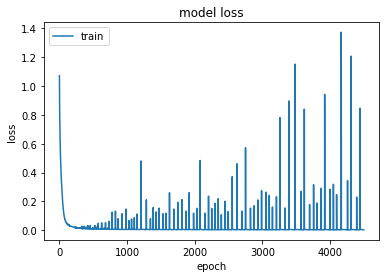

Procedure I
Statement  9:    1
Statement 84:    2
Statement  8:    3
Statement 10:    4
Statement  6:    5
Statement  4:    6
Statement  3:    7
Statement  5:    8
Statement 16:    9
Statement 22:   10
Statement 29:   11
Statement 30:   12
Statement 32:   13
Statement 33:   14
Statement 20:   15
Statement 21:   16
Statement 25:   17
Statement 27:   18
Statement 44:   19
Statement 90:   20
Statement 31:   21
Statement 34:   22
Statement 59:   23
Statement 51:   24
Statement 62:   25
Statement 56:   26
Statement 57:   27
Statement 58:   28
Statement 54:   29
Statement 49:   30
Statement 64:   31
Statement 65:   32
Statement 66:   33
Statement  1:   34
Statement 68:   35
Statement 69:   36
Statement 70:   37
Statement 71:   38
Statement 72:   39
Statement 73:   40
Statement 74:   41
Statement 75:   42
Statement 76:   43
Statement 77:   44
Statement 78:   45
Statement 79:   46
Statement 80:   47
Statement 81:   48
Statement 83:   49
Statement  2:   50
Statement 85:   51
Statement 86:   52


In [9]:
if __name__ == '__main__':
    inputstream = '../input/sort-bug/sort_bug1.csv'
    n_statement = 90
    epochs = 4500
    #m, result = get_train_data()
    m, result,n_statement = read_coverage(inputstream)
    trained_model = train_model(m,result, n_statement,epochs)
    c_virtual = create_virtual_test(n_statement)
    r_virtual = trained_model.predict(c_virtual, batch_size=None, verbose=0, steps=None)
    procedure1(r_virtual)
    procedure2(r_virtual)